



# HW1: Skip-Gram Model From Scratch

In [ ]:
%matplotlib inline
# put your student name here, you will need to train the model that prints out your name in each loss
# without the name, you will not be able to get points in train part
STUDENT_NAME = "Rohan Tikotekar"

This section imports necessary Python libraries such as NumPy and the random module. These libraries are essential for generating random training data and managing numerical computations.

In [ ]:
import numpy as np
import random
np.random.seed(0)
random.seed(0)

### 1.Create Corpus

In this section, you should first define a custom vocabulary composed of universities in Southern California (SoCal) and Northern California (NorCal). It generates a synthetic corpus by randomly pairing elements within each regional list to simulate word-context relationships.

In [ ]:
SoCal = ["UCR", "UCLA", "UCSD", "UCI", "UCSB"]
NorCal = ["UCB", "UCSC", "UCD", "UCSF", "UCM"]
vocab = SoCal + NorCal

corpus = []

# Create Corpus
for i in range(20):
  random.shuffle(SoCal)
  corpus.append((SoCal[0], SoCal[1]))

for i in range(20):
  random.shuffle(NorCal)
  corpus.append((NorCal[0], NorCal[1]))

word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for i, word in enumerate(vocab)}

vocab_size = len(vocab)

embedding_dim = 2
learning_rate = 0.02
num_neg_samples = 2

print(corpus)

[('UCSD', 'UCLA'), ('UCSD', 'UCR'), ('UCR', 'UCSD'), ('UCI', 'UCR'), ('UCR', 'UCSB'), ('UCSB', 'UCLA'), ('UCLA', 'UCSB'), ('UCI', 'UCLA'), ('UCI', 'UCSB'), ('UCLA', 'UCSB'), ('UCR', 'UCI'), ('UCI', 'UCLA'), ('UCI', 'UCR'), ('UCSB', 'UCSD'), ('UCI', 'UCSD'), ('UCSD', 'UCSB'), ('UCLA', 'UCSD'), ('UCSB', 'UCLA'), ('UCR', 'UCI'), ('UCLA', 'UCSD'), ('UCSF', 'UCD'), ('UCB', 'UCD'), ('UCM', 'UCSC'), ('UCM', 'UCD'), ('UCSF', 'UCB'), ('UCB', 'UCSC'), ('UCSC', 'UCD'), ('UCSC', 'UCB'), ('UCB', 'UCSF'), ('UCSF', 'UCD'), ('UCM', 'UCSC'), ('UCSC', 'UCD'), ('UCM', 'UCSC'), ('UCD', 'UCM'), ('UCM', 'UCB'), ('UCB', 'UCD'), ('UCM', 'UCB'), ('UCB', 'UCD'), ('UCB', 'UCSC'), ('UCSF', 'UCB')]


### 2.Define Visualization Function

Implement plotting utilities for visualizing training loss, embedding space, and cosine similarity between word vectors. (No Need to Change.)


In [ ]:
import matplotlib.pyplot as plt

# Plot loss over epochs
def plot_loss_over_epochs(loss_values, epochs):
  plt.figure(figsize=(6, 4))
  plt.plot(range(1, epochs + 1), loss_values, marker='o')
  plt.ticklabel_format(style='plain', axis='y', useOffset=False)
  plt.xlabel('Epoch')
  plt.ylabel('Average Loss')
  plt.title('Loss over Epochs')
  plt.show()

# Plot Embedding
def plot_embedding(matrix, vocab):
  plt.figure(figsize=(6, 4))
  x = matrix[:, 0]
  y = matrix[:, 1]
  plt.scatter(x, y)
  for i, word in enumerate(vocab):
    plt.annotate(word, xy=(x[i], y[i]))

  plt.title("Embedding Visualization")
  plt.show()

# Plot Similary score
def plot_cosine_similarity(matrix, vocab):

  def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

  similarities = np.array([
      cosine_similarity(matrix[0], emb) for emb in matrix
  ])

  plt.figure(figsize=(6, 4))
  plt.bar(range(len(similarities)), similarities)
  plt.xticks(range(len(similarities)), vocab)
  plt.ylim(-1.1, 1.1)
  plt.ylabel("Cosine Similarity")
  plt.title("Cosine Similarity to UCR")
  plt.grid(axis='y')

  plt.show()

### 3.Define trainable parameters (10pt)

Use Numpy to initialize two trainable embedding matrices — one for context words and one for target words — with small random values.

Here is the size for each Matrix:

1. Context Matrix:   [vocab_size, embedding_dim]
2. Target Matrix:  [vocab_size, embedding_dim]

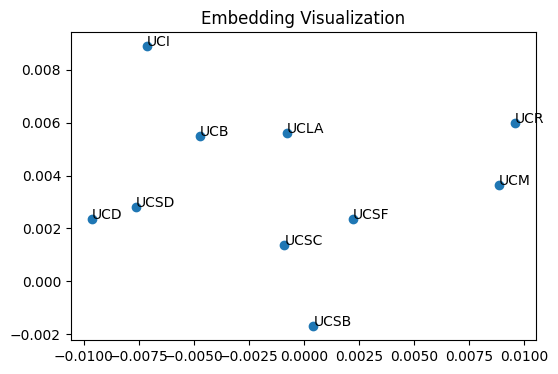

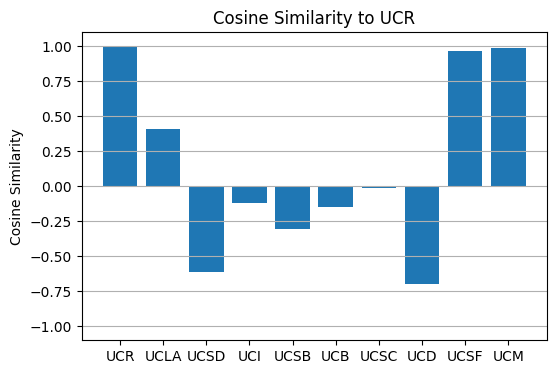

In [ ]:
def initialize_parameters(vocab_size, embedding_dim):
  # This is the context matrix having dimensions vocab_size x embedding_dim
  W1 = np.random.uniform(-0.01, 0.01, (vocab_size, embedding_dim))

  # This is the Target Matrix of dimensions vocab_size x embedding_dim
  W2 = np.random.uniform(-0.01, 0.01, (vocab_size, embedding_dim))

  return W1, W2

# visualization
W1, W2 = initialize_parameters(vocab_size, embedding_dim)
plot_embedding(W2, vocab)
plot_cosine_similarity(W2, vocab)


### 4.Define Activation Function (5pt)
Implement the sigmoid function used in the computation of prediction probabilities and gradients.


Sigmoid Function: $\sigma(z) = \frac{1}{ 1 + exp(-z)}$

In [ ]:
#! define sigmoid function
def sigmoid(z):
  z = np.clip(z, -100, 100)
  return 1 / (1 + np.exp(-z))

### 5.Define Negative Sampling (15pt)

Randomly select a set of negative word samples for each training instance, ensuring they differ from the current positive pair.

By using negative sampling, we can improve computational efficiency by approximating the full softmax over the vocabulary.


In [ ]:
def negative_sampling(word_to_index, target_index, context_index, num_neg_samples):
  """
  word_to_index: dictionary mapping word -> index
  target_index: index of the center/target word
  context_index: index of the true context word
  num_neg_samples: number of negative samples to generate
  """

  vocab_indices = list(word_to_index.values())

  # Remove the context and target indices
  candidates = [i for i in vocab_indices if i != target_index and i != context_index]

  # Randomly choose negative samples from the remaining candidates
  neg_samples = random.sample(candidates, num_neg_samples)

  return neg_samples

# test Negative Sampling
neg_samples = negative_sampling(word_to_index, word_to_index["UCR"], word_to_index["UCLA"], num_neg_samples)
print('Negative Words:')
for sample in neg_samples:
  print(index_to_word[sample])


Negative Words:
UCSD
UCSF


### 6.Forward (20pt)
Compute the positive and negative prediction scores and calculate the loss using the negative sampling technique.

Loss Function:
$L_{CE}=-\bigg[log\sigma(c_{pos}\cdot w) + \sum_{i=1}^{k}log\sigma(-c_{neg_i}\cdot w)\bigg]$

In [ ]:
def forward_negative_sampling(context_word_index, target_word_index, neg_samples, W1, W2):
  # Get context word embedding from W1
  h_context = W1[context_word_index]

  # Get target word embedding from W2
  u_target = np.dot(h_context, W2[target_word_index])

  # Positive loss: -log(sigmoid(h ⋅ u_target))
  pos_loss = -np.log(sigmoid(u_target))

  # Get embeddings of negative samples from W2
  h_neg = np.array([np.dot(h_context, W2[neg_i]) for neg_i in neg_samples])

  # Negative loss: sum over -log(sigmoid(-h ⋅ u_neg))
  neg_loss = -np.sum(np.log(sigmoid(-h_neg)))

  # Total loss
  loss = pos_loss + neg_loss

  return u_target, h_neg, loss


### 7.Backward (20pt)
Update model parameters using gradients derived from the loss function for both positive and negative samples.

Loss Function:

1. $c^{t+1}_{pos} = c^t_{pos} - \eta [\sigma(c^t_{pos}\cdot w^t)-1]w^t$

2. $c^{t+1}_{neg} = c^t_{neg} - \eta [\sigma(c^t_{neg}\cdot w^t)]w^t$

3. $w^{t+1} = w^t - \eta \bigg[ [\sigma (c_{pos} \cdot w^t - 1)]c_{pos} + \sum_{i=1}^{k}[\sigma (c_{neg_i}\cdot w^t)] c_{neg_i}\bigg]$

In [ ]:
def backward_negative_sampling(
    u_target,
    u_neg_samples,
    context_word_index,
    target_word_index,
    neg_samples_idx,
    W1,
    W2,
    learning_rate):
  """
  Updates W1 and W2 using gradients from Skip-Gram with Negative Sampling.
  """

  # 1️⃣ Positive sample gradient
  grad_pos = sigmoid(u_target) - 1  # derivative of -log(sigmoid(dot))

  # Update W2 for positive context word
  W2[target_word_index] -= learning_rate * grad_pos * W1[context_word_index]

  # Update W1 for context word (due to positive pair)
  W1[context_word_index] -= learning_rate * grad_pos * W2[target_word_index]

  # 2️⃣ Negative sample gradient
  grad_neg = sigmoid(u_neg_samples)  # derivative of -log(sigmoid(-dot))

  for i, neg_index in enumerate(neg_samples_idx):
      # Update W2 for each negative sample
      W2[neg_index] -= learning_rate * grad_neg[i] * W1[context_word_index]

      # Update W1 for context word (cumulative gradient from negative samples)
      W1[context_word_index] -= learning_rate * grad_neg[i] * W2[neg_index]


### 8.Train Skip-Gram Model (20pt)

Loop through the corpus over multiple epochs, applying forward and backward passes to learn word embeddings. You can train the model to produce meaningful word embeddings that capture contextual similarities.


In [ ]:
def train_skip_gram_negative_sampling(corpus, word_to_index, vocab_size, embedding_dim, learning_rate, epochs, num_neg_samples):
  """
  Train Word2Vec Skip-Gram with Negative Sampling using Numpy.
  """
  # Initialize parameters
  W1, W2 = initialize_parameters(vocab_size, embedding_dim)
  total_loss = []

  for epoch in range(epochs):
      loss_epoch = 0
      for context_word, target_word in corpus:
          # Convert words to indices
          context_word_index = word_to_index[context_word]
          target_word_index = word_to_index[target_word]

          # Sample negative word indices
          neg_samples_index = negative_sampling(word_to_index, target_word_index, context_word_index, num_neg_samples)

          # Forward pass
          u_target, u_neg_samples, loss = forward_negative_sampling(
              context_word_index, target_word_index, neg_samples_index, W1, W2
          )
          loss_epoch += loss

          # Backward pass / update
          backward_negative_sampling(
              u_target, u_neg_samples, context_word_index, target_word_index,
              neg_samples_index, W1, W2, learning_rate
          )

      avg_loss = loss_epoch / len(corpus)
      print(f"{STUDENT_NAME} Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
      total_loss.append(avg_loss)

  return W1, W2, total_loss


### 9.Run Skip-Gram Model

Executes the training process and visualizes the final word embeddings.




Rohan Tikotekar Epoch 1/10, Loss: 2.0794
Rohan Tikotekar Epoch 2/10, Loss: 2.0794
Rohan Tikotekar Epoch 3/10, Loss: 2.0795
Rohan Tikotekar Epoch 4/10, Loss: 2.0794
Rohan Tikotekar Epoch 5/10, Loss: 2.0794
Rohan Tikotekar Epoch 6/10, Loss: 2.0794
Rohan Tikotekar Epoch 7/10, Loss: 2.0794
Rohan Tikotekar Epoch 8/10, Loss: 2.0794
Rohan Tikotekar Epoch 9/10, Loss: 2.0794
Rohan Tikotekar Epoch 10/10, Loss: 2.0794


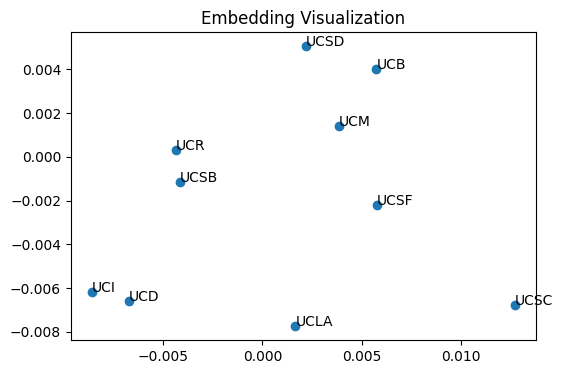

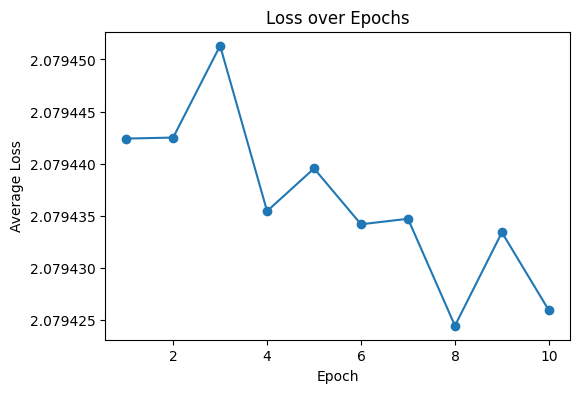

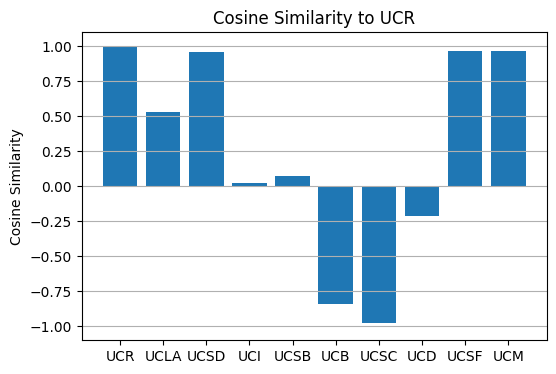

In [ ]:
epochs = 10
W1, W2, total_loss = train_skip_gram_negative_sampling(corpus, word_to_index, vocab_size, embedding_dim, learning_rate, epochs, num_neg_samples)
plot_embedding(W1, vocab)
plot_loss_over_epochs(total_loss, epochs)
plot_cosine_similarity(W2, vocab)

Rohan Tikotekar Epoch 1/100, Loss: 2.0794
Rohan Tikotekar Epoch 2/100, Loss: 2.0794
Rohan Tikotekar Epoch 3/100, Loss: 2.0794
Rohan Tikotekar Epoch 4/100, Loss: 2.0794
Rohan Tikotekar Epoch 5/100, Loss: 2.0794
Rohan Tikotekar Epoch 6/100, Loss: 2.0794
Rohan Tikotekar Epoch 7/100, Loss: 2.0794
Rohan Tikotekar Epoch 8/100, Loss: 2.0794
Rohan Tikotekar Epoch 9/100, Loss: 2.0794
Rohan Tikotekar Epoch 10/100, Loss: 2.0794
Rohan Tikotekar Epoch 11/100, Loss: 2.0794
Rohan Tikotekar Epoch 12/100, Loss: 2.0794
Rohan Tikotekar Epoch 13/100, Loss: 2.0794
Rohan Tikotekar Epoch 14/100, Loss: 2.0794
Rohan Tikotekar Epoch 15/100, Loss: 2.0794
Rohan Tikotekar Epoch 16/100, Loss: 2.0794
Rohan Tikotekar Epoch 17/100, Loss: 2.0794
Rohan Tikotekar Epoch 18/100, Loss: 2.0793
Rohan Tikotekar Epoch 19/100, Loss: 2.0793
Rohan Tikotekar Epoch 20/100, Loss: 2.0794
Rohan Tikotekar Epoch 21/100, Loss: 2.0793
Rohan Tikotekar Epoch 22/100, Loss: 2.0793
Rohan Tikotekar Epoch 23/100, Loss: 2.0793
Rohan Tikotekar Epoc

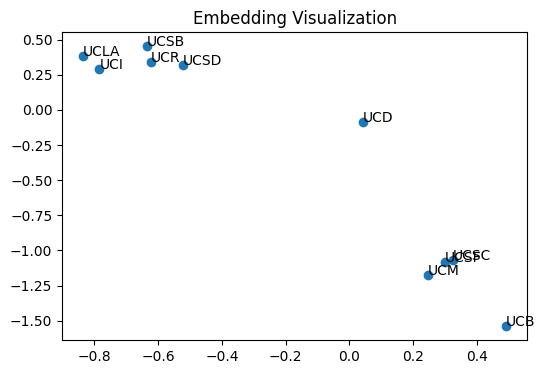

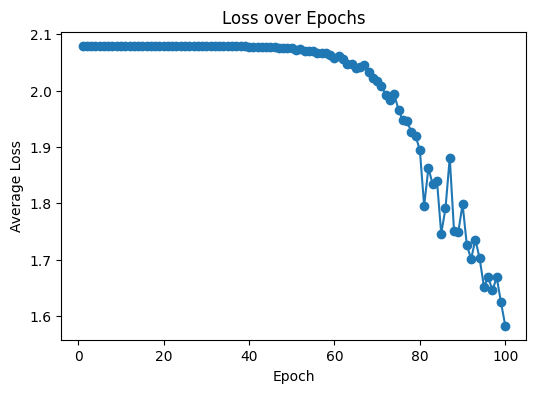

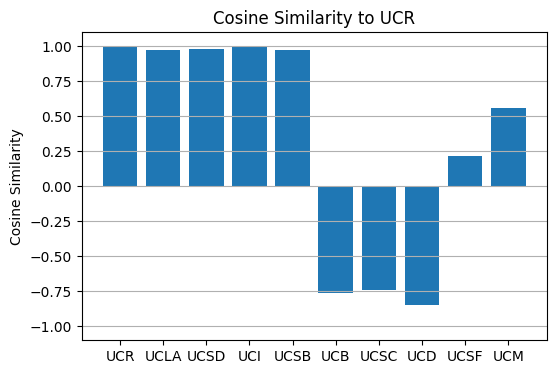

In [ ]:

epochs = 100
W1, W2, total_loss = train_skip_gram_negative_sampling(corpus, word_to_index, vocab_size, embedding_dim, learning_rate, epochs, num_neg_samples)
plot_embedding(W1, vocab)
plot_loss_over_epochs(total_loss, epochs)
plot_cosine_similarity(W2, vocab)

Rohan Tikotekar Epoch 1/200, Loss: 2.0794
Rohan Tikotekar Epoch 2/200, Loss: 2.0794
Rohan Tikotekar Epoch 3/200, Loss: 2.0794
Rohan Tikotekar Epoch 4/200, Loss: 2.0794
Rohan Tikotekar Epoch 5/200, Loss: 2.0794
Rohan Tikotekar Epoch 6/200, Loss: 2.0794
Rohan Tikotekar Epoch 7/200, Loss: 2.0794
Rohan Tikotekar Epoch 8/200, Loss: 2.0794
Rohan Tikotekar Epoch 9/200, Loss: 2.0794
Rohan Tikotekar Epoch 10/200, Loss: 2.0794
Rohan Tikotekar Epoch 11/200, Loss: 2.0794
Rohan Tikotekar Epoch 12/200, Loss: 2.0794
Rohan Tikotekar Epoch 13/200, Loss: 2.0794
Rohan Tikotekar Epoch 14/200, Loss: 2.0794
Rohan Tikotekar Epoch 15/200, Loss: 2.0794
Rohan Tikotekar Epoch 16/200, Loss: 2.0794
Rohan Tikotekar Epoch 17/200, Loss: 2.0794
Rohan Tikotekar Epoch 18/200, Loss: 2.0794
Rohan Tikotekar Epoch 19/200, Loss: 2.0794
Rohan Tikotekar Epoch 20/200, Loss: 2.0794
Rohan Tikotekar Epoch 21/200, Loss: 2.0794
Rohan Tikotekar Epoch 22/200, Loss: 2.0794
Rohan Tikotekar Epoch 23/200, Loss: 2.0794
Rohan Tikotekar Epoc

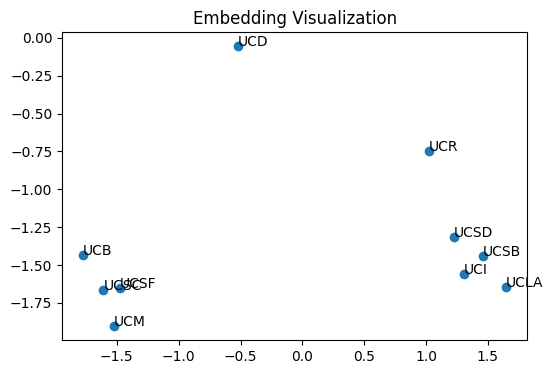

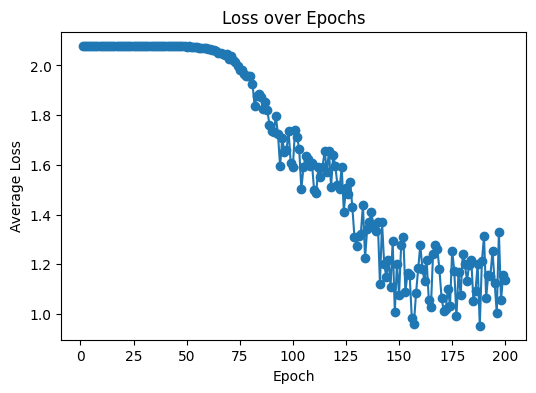

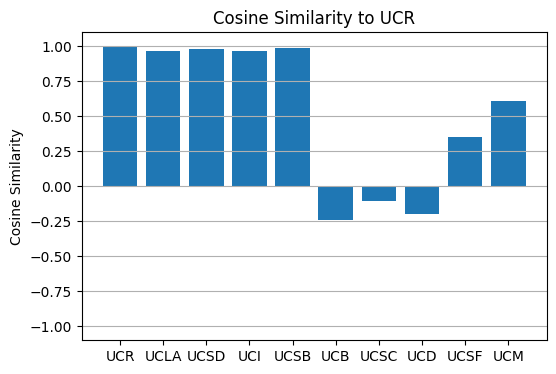

In [ ]:
epochs = 200
W1, W2, total_loss = train_skip_gram_negative_sampling(corpus, word_to_index, vocab_size, embedding_dim, learning_rate, epochs, num_neg_samples)
plot_embedding(W1, vocab)
plot_loss_over_epochs(total_loss, epochs)
plot_cosine_similarity(W2, vocab)

### 10.Use Pre-trained Word2Vector Model (10pt)

In this section, you should use pretrained GloVe word embeddings from the gensim library to compute the semantic similarity between sentences.



In [ ]:
!pip install gensim --upgrade --force-reinstall
!pip install numpy==1.26.4


  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (83 kB)
  Att

^C


In [ ]:
# Step 1: Install gensim if needed
!pip install --quiet gensim

# Step 2: Import libraries
import numpy as np
from nltk.tokenize import word_tokenize
import gensim.downloader
import nltk
import string
from nltk.corpus import stopwords

# Step 3: Download NLTK resources
nltk.download('punkt')        # ✅ correct tokenization model
nltk.download('stopwords')

# Step 4: List and load GloVe model
print("Available models:", list(gensim.downloader.info()['models'].keys()))

# Load 25-dim GloVe vectors
models = gensim.downloader.load('glove-twitter-25')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Available models: ['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
def review_to_vector(review_text):
    # Tokenize and clean the review
    words = word_tokenize(review_text.lower())
    words = [word for word in words if word not in string.punctuation]
    words = [word for word in words if word not in stopwords.words('english')]

    # Keep only valid words in the GloVe model
    valid_words = [word for word in words if word in models]

    if not valid_words:
        return np.zeros(models.vector_size)

    # Average the GloVe vectors for valid words
    avg_vec = np.mean([models[word] for word in valid_words], axis=0)

    return avg_vec

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


In [ ]:
nltk.download('punkt_tab')

# Three Sentences.
sent1 = "The cat is sleeping on the sofa."
sent2 = "A cat is napping on the couch."
sent3 = "The spaceship landed on Mars after a six-month journey."

# Convert reviews to vectors
vec1 = review_to_vector(sent1)
vec2 = review_to_vector(sent2)
vec3 = review_to_vector(sent3)

# Calculate similarities
sim1 = cosine_similarity(vec1, vec2)
sim2 = cosine_similarity(vec1, vec3)

print(f"sent1-sent2 similarity: {sim1:.4f}")
print(f"sent1-sent3 similarity: {sim2:.4f}")

sent1-sent2 similarity: 0.9441
sent1-sent3 similarity: 0.6561


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
